# Plotting demographics of participants, and healthcare workers

In [1]:
# Imports

# Usual imports
import os
import sys
import time
import datetime
import json
import csv
import glob
import pprint
import importlib
from tqdm import tqdm
from collections import Counter

import pandas as pd

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

import itertools
import time
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error

%matplotlib inline
plt.style.use('seaborn-talk')

from matplotlib import rc
rc('font',**{'family':'serif','serif':['FreeSerif']})
rc('text', usetex=False)
from matplotlib import rc
sns.set_palette("Set2")

# Plotting
import matplotlib.pyplot as plt
from matplotlib import cm, style
from matplotlib.ticker import FixedLocator
from matplotlib.dates import DateFormatter

import seaborn as sns
from IPython.display import Image
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter

# For regression
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Custom modules
sys.path.insert(0, '../')
import psychometry
import parser
import utils

# Some edits to matplotlib
# https://towardsdatascience.com/simple-ways-to-improve-your-matplotlib-b64eebccfd5
# https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08
#plt.rcParams.update({'font.size': 20})
style.use('seaborn-talk') #sets the size of the charts

# This is the color of sh.rice.edu/covid-sense website background. It is NOT white
bg_color = (0.96862745, 0.96862745, 0.96862745)

# Convert a timestamp into time string
d2s = lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%B %d')

# Save all files here:
#saveroot = '/home/vishwanath/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'
saveroot = 'D:/Dropbox/Apps/Overleaf/CovidSense Analysis/figures/'

In [2]:
# Load database
dbname = '../data/db_snapshot.json'

with open(dbname, 'rb') as readfile:
    db = json.load(readfile)

lens = np.array([len(db[key]['timestamps']) for key in db])
print(lens.sum())


18783


[234 420 356 169]


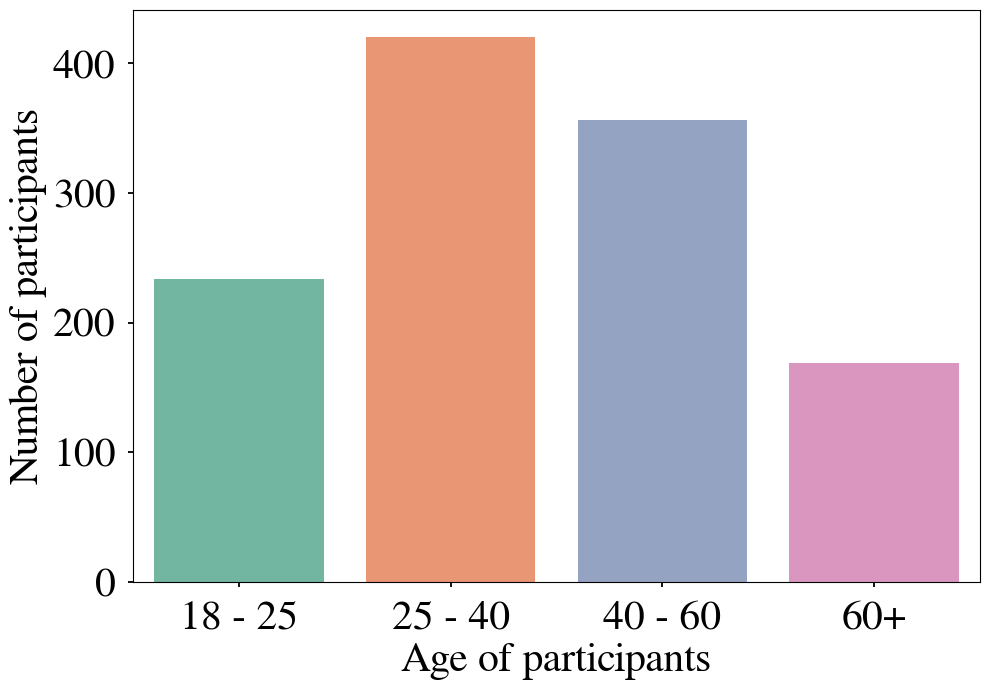

In [3]:
# Plot a histogram of participants by age
ages = utils.getall(db, 'age')

bins = [18, 25, 40, 60, 100]

vals, bins = np.histogram(ages, bins)
print(vals)

fig = plt.figure(dpi=100, figsize=(10, 7))
fontsize = 30
sns.barplot([0, 1, 2, 3], vals)
plt.xlabel('Age of participants', fontsize=fontsize)
plt.ylabel('Number of participants', fontsize=fontsize)
plt.xticks([0, 1, 2, 3], labels=['18 - 25', '25 - 40', '40 - 60', '60+'], fontsize=fontsize)
plt.yticks([0, 100, 200, 300, 400], fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/age_distribution.pdf'%saveroot)
plt.show()

[741 436   8]


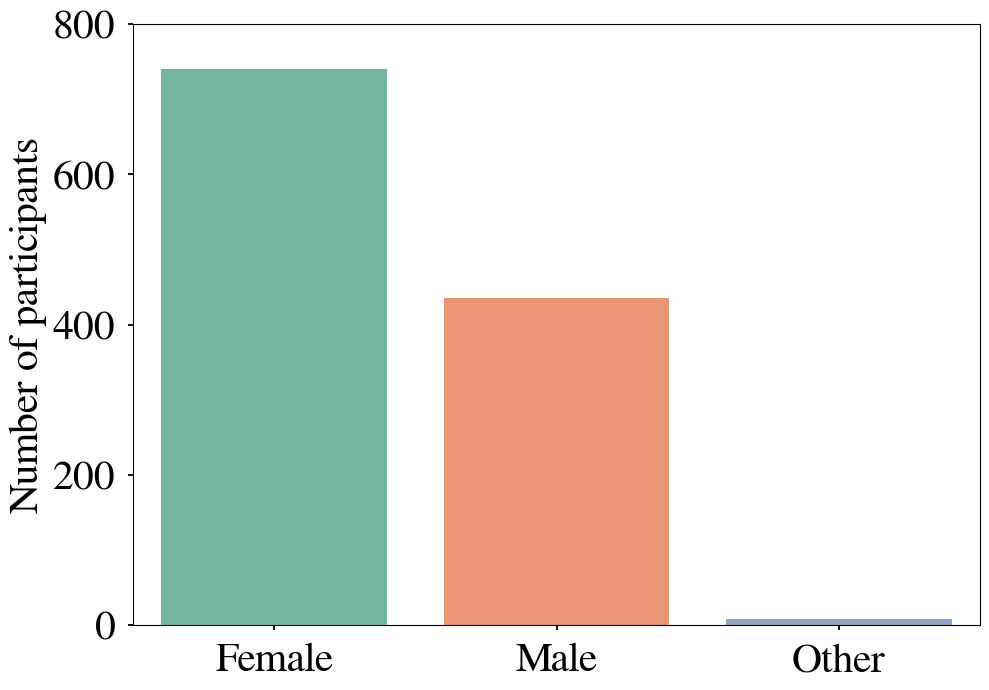

In [4]:
# Plot distribution by gender
genders = utils.getall(db, 'gender')

gender_counter = Counter(genders)
del gender_counter['prefer not to answer']

vals = np.array(list(gender_counter.values()))
print(vals)
labels = [label.capitalize() for label in list(gender_counter.keys())]

fig = plt.figure(dpi=100, figsize=(10, 7))
sns.barplot(labels, vals)
plt.xticks(fontsize=fontsize)
plt.yticks([0, 200, 400, 600, 800], fontsize=fontsize)
plt.ylabel('Number of participants', fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/gender_distribution.pdf'%saveroot)
plt.show()

310 91 50 739


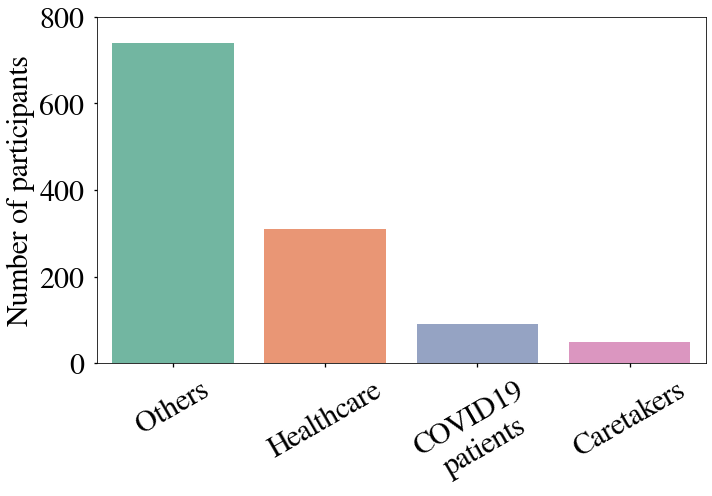

In [5]:
# Distribution by status
n_total = len(db)
n_healthcare = len([key for key in db if db[key]['healthcare_worker']])
n_covid = len([key for key in db if len(db[key]['I']) > 0])
n_caretaker = len([key for key in db if len(db[key]['M']) > 0])
n_others = n_total - n_healthcare - n_covid - n_caretaker

print(n_healthcare, n_covid, n_caretaker, n_others)

fig, ax = plt.subplots(figsize=(10, 7))
sns.barplot(['Others', 'Healthcare', 'COVID19\npatients', 'Caretakers'], 
            [n_others, n_healthcare, n_covid, n_caretaker])

plt.ylabel('Number of participants', fontsize=fontsize)
plt.xticks(fontsize=fontsize, rotation=30)
plt.yticks([0, 200, 400, 600, 800], fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/status_distribution.pdf'%saveroot)
plt.show()

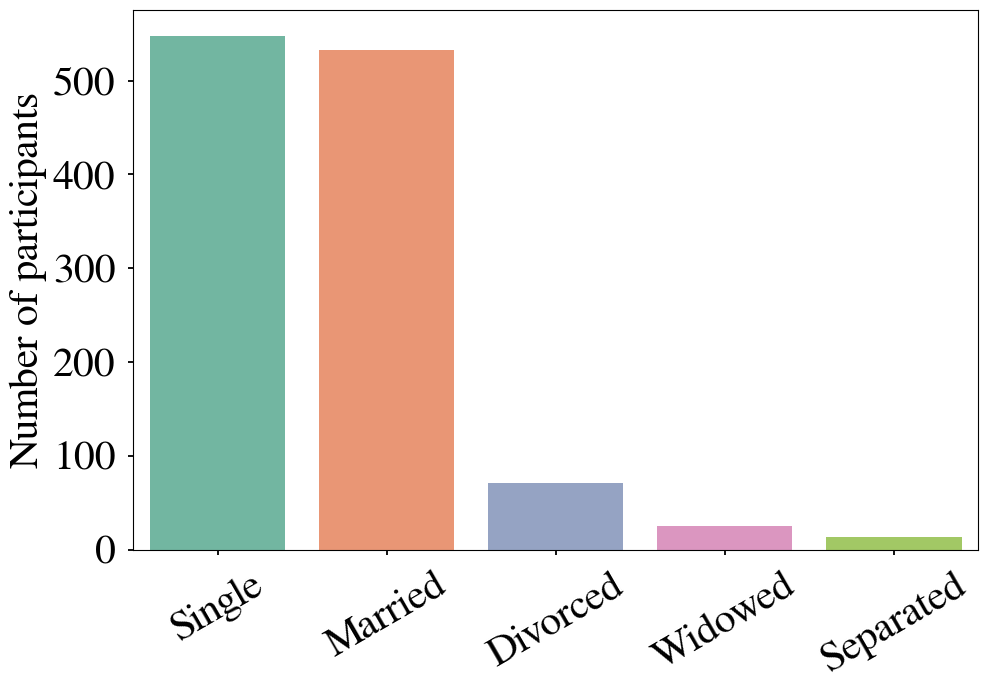

In [6]:
# Marital status
marital_counter = Counter(utils.getall(db, 'marital_status'))
vals = np.array(list(marital_counter.values()))
labels = np.array([label.capitalize() for label in list(marital_counter.keys())])

indices = np.argsort(vals)[::-1]
vals = vals[indices]
labels = labels[indices]

fig, ax = plt.subplots(dpi=100, figsize=(10, 7))
sns.barplot(labels, vals)
plt.ylabel('Number of participants', fontsize=fontsize)
plt.xticks(fontsize=fontsize, rotation=30)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/marital_distribution.pdf'%saveroot)
plt.show()

{'Cardio-vascular': 190,
 'Mental health': 491,
 'None': 537,
 'Other health issues': 71,
 'Pulmonary': 118}


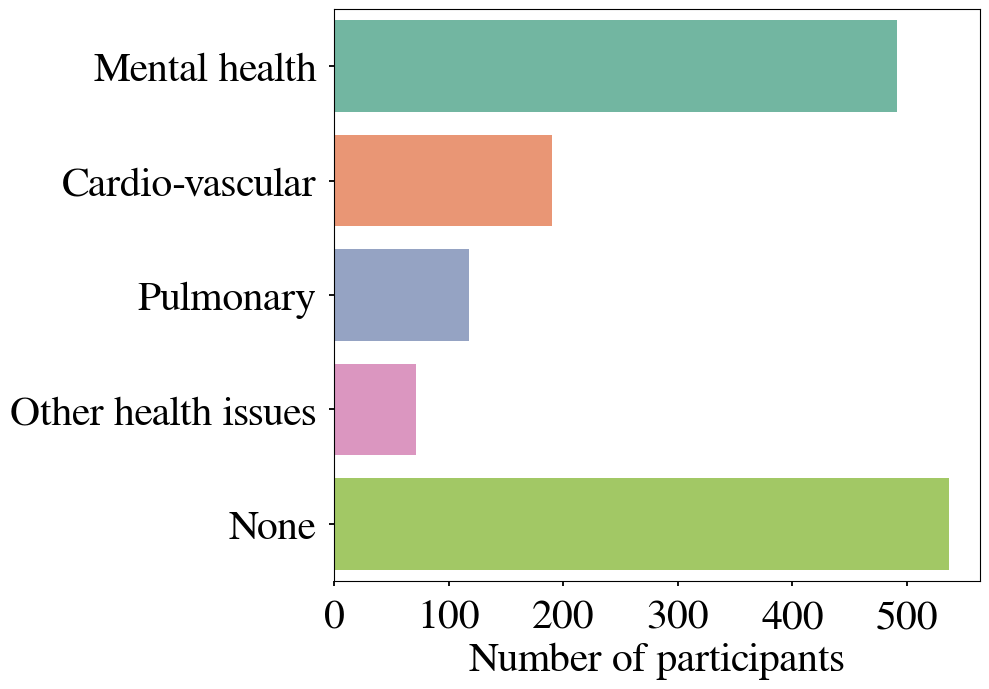

In [14]:
# Preexisting conditions
pre_physical = utils.getall(db, 'pre_physical')
pre_mental = utils.getall(db, 'pre_mental')

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()

conversion_dict = {
    'None': ['none of the above', 'None', '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}
total_counter = {key:0 for key in conversion_dict}
camsr_dict = {key:[] for key in conversion_dict}

for idx in range(len(pre_physical)):
    physical = pre_physical[idx]
    mental = pre_mental[idx]
    
    if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
       len(set(conversion_dict['None']).intersection(mental)) > 0:
        total_counter['None'] += 1
    else:
        if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
            total_counter['Mental health'] += 1
        if len(set(conversion_dict['Cardio-vascular']).intersection(physical)) > 0:
            total_counter['Cardio-vascular'] += 1
        elif len(set(conversion_dict['Pulmonary']).intersection(physical)) > 0:
            total_counter['Pulmonary'] += 1
        elif len(set(conversion_dict['Other health issues']).intersection(physical)) > 0:
            total_counter['Other health issues'] += 1

pprint.pprint(total_counter)

names = np.array([key.capitalize() for key in total_counter])
values = np.array([total_counter[key] for key in total_counter])
#indices = np.argsort(values)[::-1]
indices = [1, 2, 3, 4, 0]

fig, ax = plt.subplots(dpi=100, figsize=(10, 7))
handle = sns.barplot(values[indices], names[indices])
plt.xlabel('Number of participants', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/preexisting_distribution.pdf'%saveroot)
plt.show()

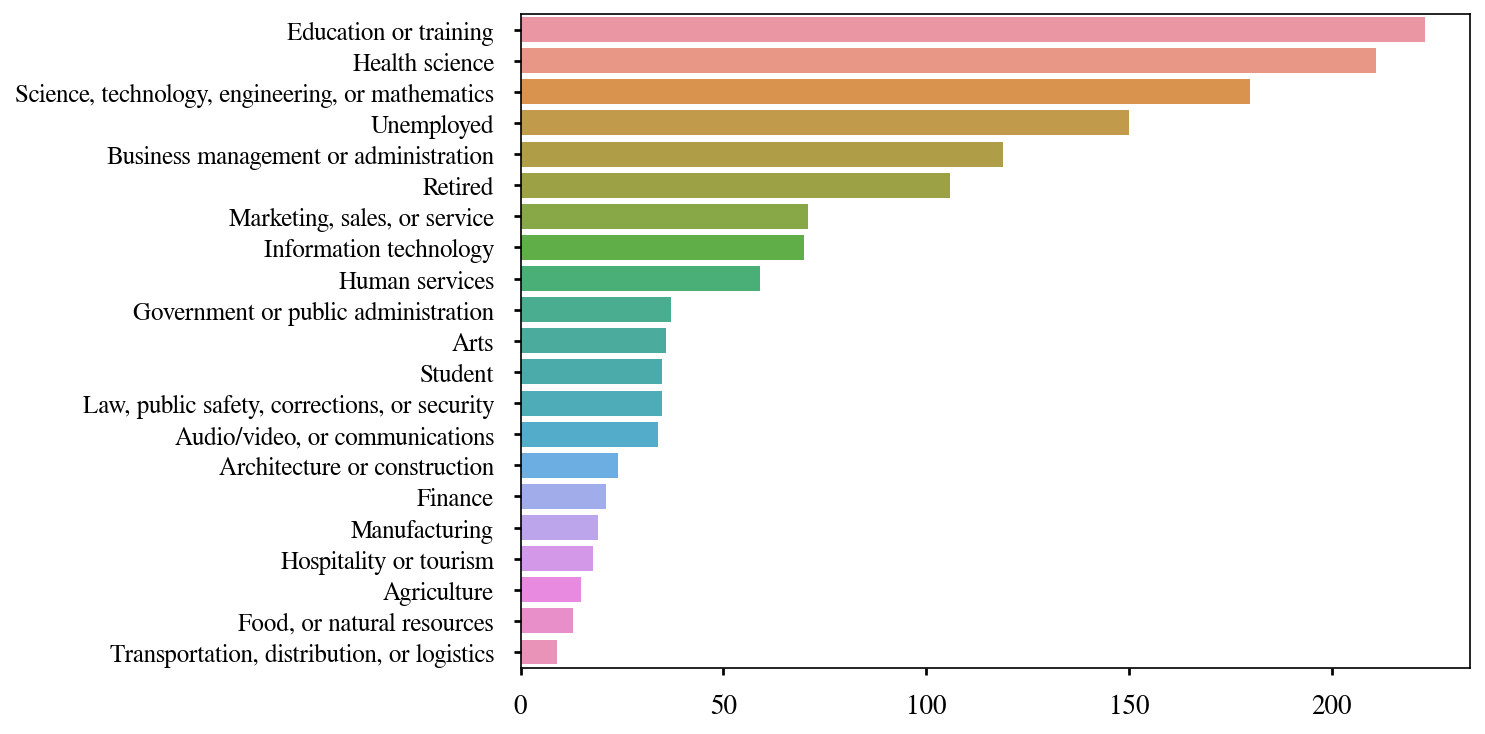

In [12]:
# Professions
professions = utils.cat_arrays(db, 'jobs')

pro_counter = Counter(professions)
labels = np.array([label.capitalize() for label in list(pro_counter.keys())])
values = np.array(list(pro_counter.values()))

valid_indices = np.where(values > 4)
labels = labels[valid_indices]
values = values[valid_indices]

indices = np.argsort(values)[::-1]
labels = labels[indices]
values = values[indices]

fig = plt.figure(dpi=150, figsize=(10, 5))
sns.barplot(values, labels)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('%s/profession_distribution.pdf'%saveroot)
plt.show()

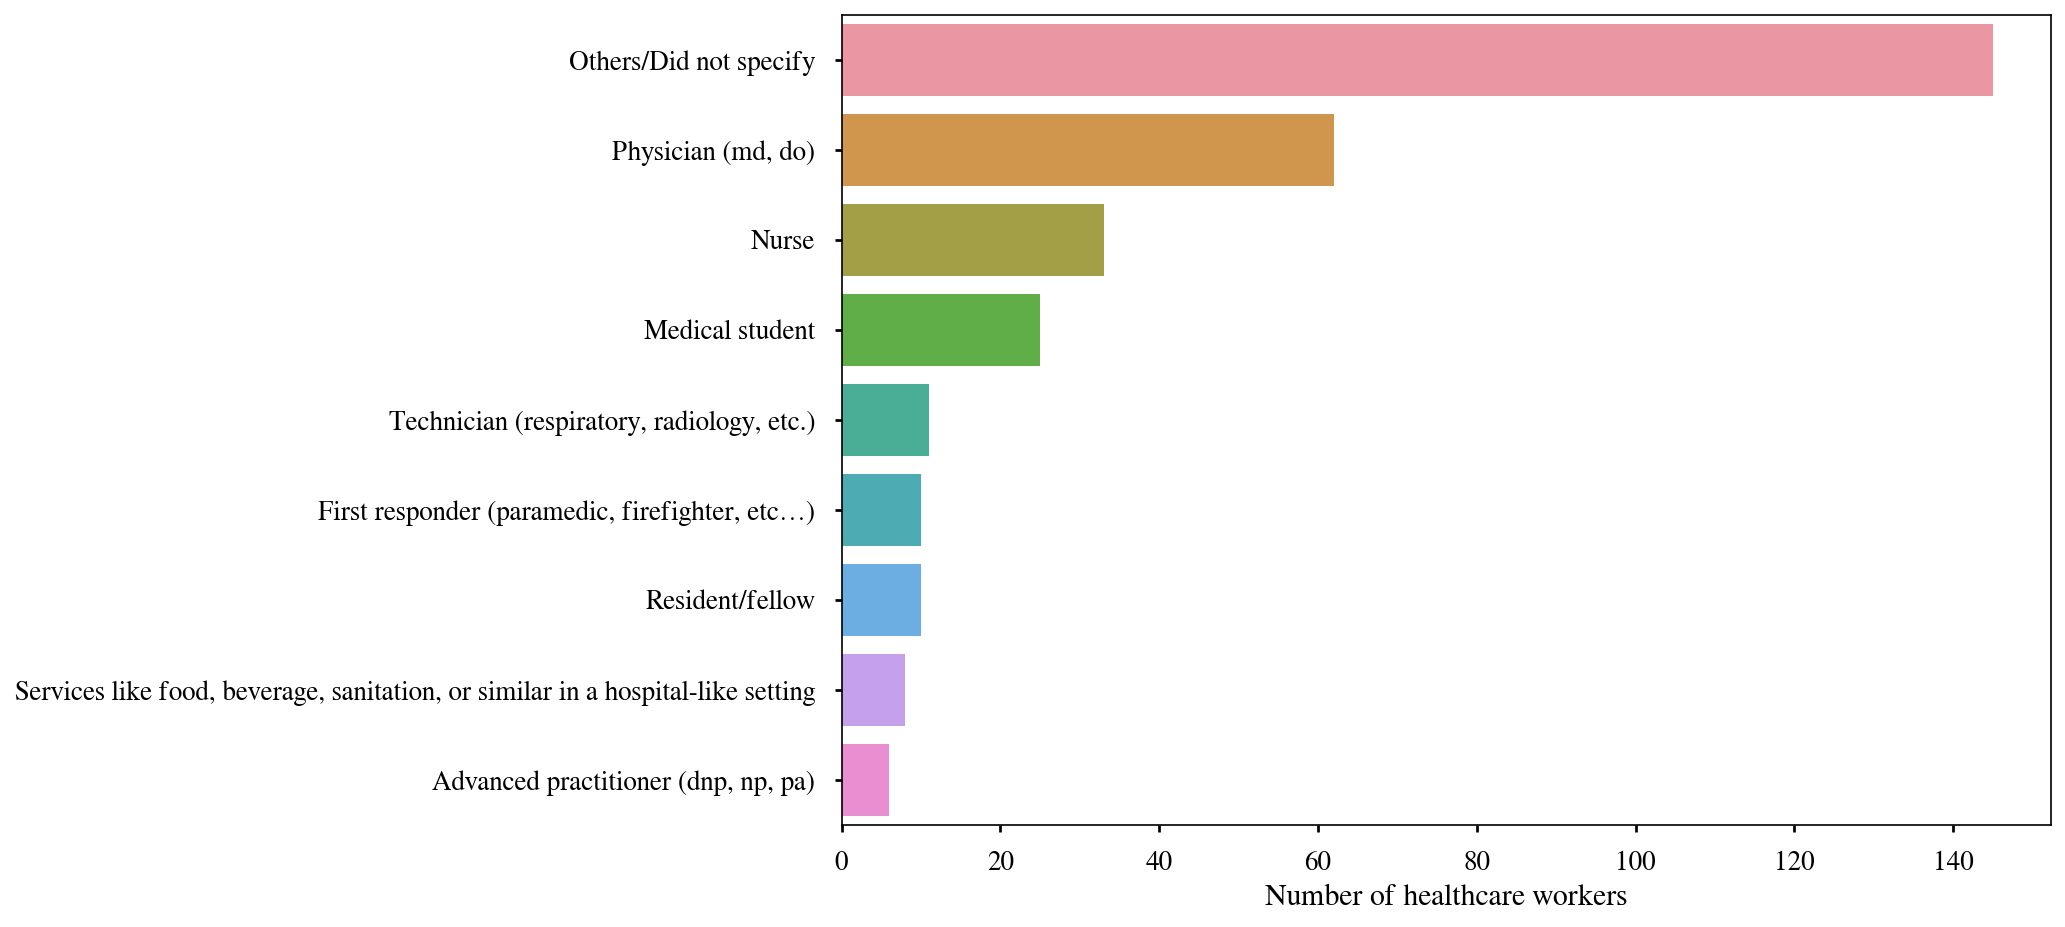

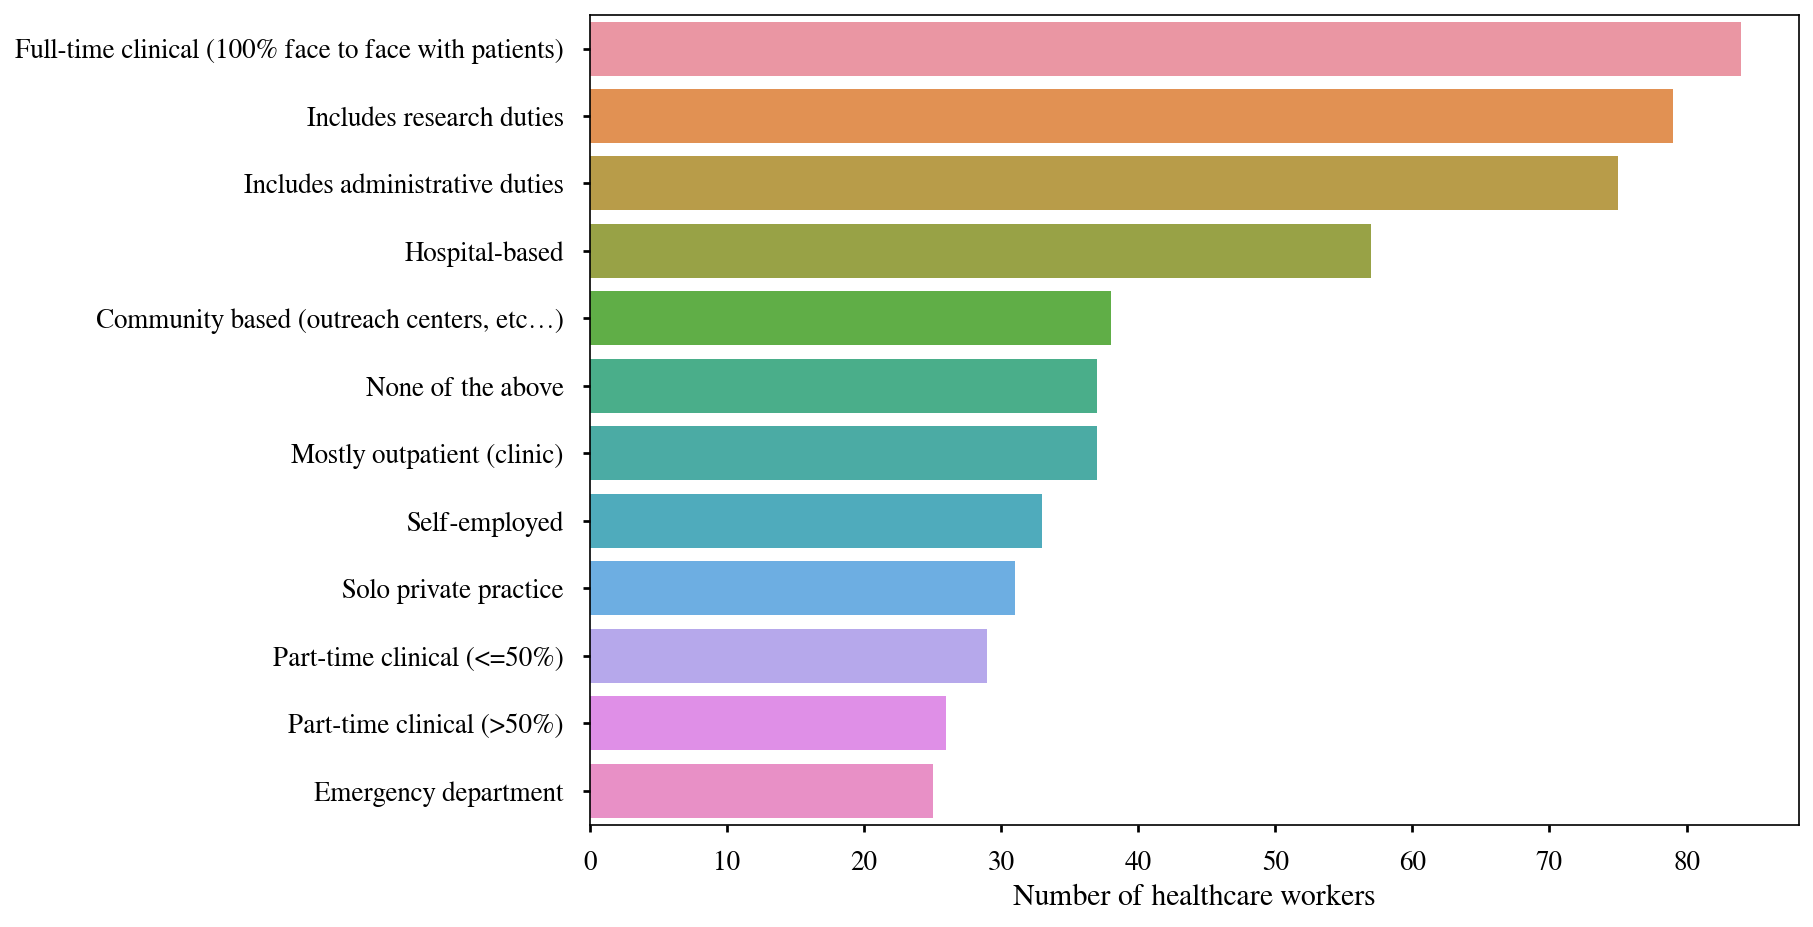

In [34]:
# Plot some demographics for healthcare workers
health_db = {key:db[key] for key in db if db[key]['healthcare_worker'] and 'healthcare_speciality' in db[key]}
hdb2 = {key:db[key] for key in db if db[key]['healthcare_worker']}

specialities = []

for key in health_db:
    speciality = health_db[key]['healthcare_speciality']
    
    if type(speciality) == str:
        specialities.append(json.loads(speciality)['Speciality'])
    else:
        specialities += speciality

healthcare_jobs = Counter(utils.getall(hdb2, 'healthcare_job'))
jobs = np.array([name.replace('I am a ', '').replace('I work in ', '').capitalize() for name in list(healthcare_jobs.keys())])
values = np.array(list(healthcare_jobs.values()))

indices = np.argsort(values)[::-1]
jobs[0] = 'Others/Did not specify'

fig = plt.figure(dpi=150)
sns.barplot(values[indices], jobs[indices])
plt.xlabel('Number of healthcare workers')
plt.show()

healthcare_work = Counter(utils.cat_arrays(hdb2, 'healthcare_work'))

del healthcare_work['(empty)']

works = np.array([name.capitalize() for name in list(healthcare_work.keys())])
values = np.array(list(healthcare_work.values()))

indices = np.argsort(values)[::-1]

fig = plt.figure(dpi=150)
sns.barplot(values[indices], works[indices])
plt.xlabel('Number of healthcare workers')
plt.show()

USA: 2.0 +/- 0.6
Others: 2.2 +/- 0.5
India: 2.2 +/- 0.5
United Kingdom: 2.2 +/- 0.6
Lebanon: 2.2 +/- 0.0
South Africa: 2.2 +/- 0.5
Mexico: 2.3 +/- 0.6
65


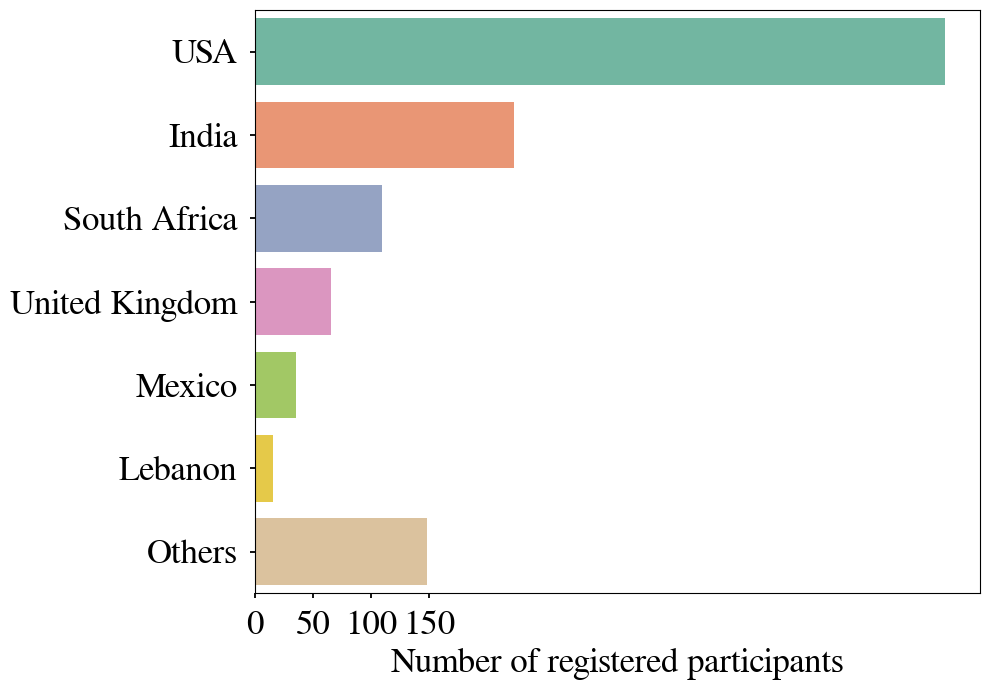

In [116]:
# Countries!
hdb = {key:db[key] for key in db if db[key]['healthcare_worker']}
countries = utils.getall(db, 'country')

decoder = {'United States of America': 'USA',
         'India': 'India',
         'South Africa': 'South Africa',
         'United Kingdom': 'United Kingdom',
         'México': 'Mexico',
         None: 'Others',
         'لبنان  Lebanon': 'Lebanon',
         'France': 'Others',
         'España': 'Others',
         'Canada': 'Others',
         'Brasil': 'Others',
         'Norge': 'Others',
         'Deutschland': 'Others',
         'United States': 'USA',
         'تونس': 'Others',
         'ประเทศไทย': 'Others',
         'Argentina': 'Others',
         'Україна': 'Others',
         'Indonesia': 'Others',
         'China 中国': 'Others',
         'Bosna i Hercegovina': 'Others',
         'قطر Qatar': 'Others',
         'Sverige': 'Others',
         'Türkiye': 'Others',
         'Россия': 'Others',
         'Australia': 'Others',
         'Ireland': 'Others',
         'Österreich': 'Others',
         'New Zealand': 'Others',
         'Italia': 'Others',
         'Ελλάδα': 'Others',
         'Chile': 'Others',
         'Isle of Man': 'Others',
         'سوريا': 'Others',
         'Singapore': 'Others',
         'Polska': 'Others',
         'Costa Rica': 'Others',
         'Latvija': 'Others',
         'Philippines': 'Others',
         'Portugal': 'Others',
         'Ethiopia': 'Others',
         'Việt Nam': 'Others',
         'Somalia / الصومال': 'Others',
         'Switzerland': 'Others',
         'België - Belgique - Belgien': 'Others',
         'Haiti': 'Others',
         'Peru': 'Others',
         'Egypt / مصر': 'Others',
         '대한민국': 'Others',
         'Magyarország': 'Others',
         'El Salvador': 'Others',
         'România': 'Others',
         'لبنان': 'Others',
         "Côte d'Ivoire": 'Others',
         'Sri Lanka': 'Others',
         'Nigeria': 'Others',
         'Angola': 'Others',
         'Liberia': 'Others',
         'Nepal': 'Others',
         'Eesti': 'Others',
         'Malawi': 'Others',
         'Iraq': 'Others',
         'Nederland': 'Others',
         'Mauritius': 'Others',
         'Mozambique': 'Others'}

country_counter = Counter(countries)

country_counter_cleaned = dict()
camsr_dict = dict()
ipip_dict = dict()

#for key in country_counter:
#    try:
#        country_counter_cleaned[decoder[key]] += country_counter[key]
#    except KeyError:
#        country_counter_cleaned[decoder[key]] = 0
#        country_counter_cleaned[decoder[key]] += country_counter[key]

for key in db:
    country = db[key]['country']
    try:
        country_counter_cleaned[decoder[country]] += 1
        if 'camsr' in db[key]:
            camsr_dict[decoder[country]].append(db[key]['camsr'])
        if 'ipip' in db[key]:
            ipip_dict[decoder[country]].append(db[key]['ipip'])
    except KeyError:
        country_counter_cleaned[decoder[country]] = 0
        camsr_dict[decoder[country]] = []
        ipip_dict[decoder[country]] = []

        country_counter_cleaned[decoder[country]] += 1
        if 'camsr' in db[key]:
            camsr_dict[decoder[country]].append(db[key]['camsr'])
        if 'ipip' in db[key]:
            ipip_dict[decoder[country]].append(db[key]['ipip'])

camsr_dict = {key:np.array(camsr_dict[key]) for key in camsr_dict}
camsr_mean = {key:camsr_dict[key].mean() for key in camsr_dict}
camsr_std = {key:camsr_dict[key].std() for key in camsr_dict}

ipip_dict = {key:np.array(ipip_dict[key]) for key in ipip_dict}
ipip_mean = {key:ipip_dict[key].mean(0) for key in ipip_dict}
ipip_std = {key:ipip_dict[key].std(0) for key in ipip_dict}

idx = 4
for key in ipip_mean:
    print('%s: %.1f +/- %.1f'%(key, ipip_mean[key][idx], ipip_std[key][idx]))

labels = np.array(list(country_counter_cleaned.keys()))
values = np.array(list(country_counter_cleaned.values()))

indices = np.argsort(values)[::-1]

labels = labels[indices]
values = values[indices]

others = values[2]
values[2:-1] = values[3:]
values[-1] = others

labels[2:-1] = labels[3:]
labels[-1] = 'Others'

print(len(country_counter))

fig = plt.figure(dpi=100, figsize=(10, 7))
fontsize = 25
sns.barplot(values, labels)
plt.xlabel('Number of registered participants', fontsize=fontsize)
plt.xticks([0, 50, 100, 150], fontsize=25)
plt.yticks(fontsize=fontsize)
plt.tight_layout()
plt.savefig('%s/country_distribution.pdf'%saveroot)
plt.show()

In [127]:
# IPIP analysis!
ipip_db = {key:db[key] for key in db if 'ipip' in db[key] and db[key]['ipip'] != 'not supplied' and\
           'camsr' in db[key] and len(db[key]['QIDS']) > 1 and len(db[key]['A']) > 0}

# IPIP interpretation:
# Extraversion: Higher value means extroverted
# Agreebleness: Higher value means more agreeable
# Conscientiousness: Higher values means likes order
# Neuroticism: Higher value means mood swings
# Imaginativeness: Higher value means vivid imagination

data_dict = {'Extraversion': np.array([ipip_db[key]['ipip'][0] for key in ipip_db]),
             'Agreeableness': np.array([ipip_db[key]['ipip'][1] for key in ipip_db]),
             'Conscientousness': np.array([ipip_db[key]['ipip'][2] for key in ipip_db]),
             'Neuroticism': np.array([ipip_db[key]['ipip'][3] for key in ipip_db]),
             'Imaginativeness': np.array([ipip_db[key]['ipip'][4] for key in ipip_db]),
             'Gender': np.array([ipip_db[key]['gender'] for key in ipip_db]),
             'Mindfulness': np.array([ipip_db[key]['camsr'] for key in ipip_db]),
             'QIDS': np.array([list(ipip_db[key]['QIDS'].values())[0] for key in ipip_db]),
             'Mood': np.array([ipip_db[key]['A'][-1]['mood'] for key in ipip_db]),
             'Country': np.array([ipip_db[key]['country'] for key in ipip_db]),
             'CAMS-R': np.array([ipip_db[key]['camsr'] for key in ipip_db])}

ipip_pd = pd.DataFrame.from_dict(data_dict)
ipip_pd.groupby(by='Country').agg('mean')

,Extraversion,Agreeableness,Conscientousness,Neuroticism,Imaginativeness,Mindfulness,QIDS,Mood,CAMS-R
Country,,,,,,,,,
Australia,2.500000,2.250000,2.000000,2.250000,2.000000,28.000000,10.000000,2.000000,28.000000
Brasil,2.000000,2.000000,1.875000,1.875000,1.750000,23.000000,7.500000,1.500000,23.000000
Canada,1.875000,0.500000,1.750000,2.250000,2.125000,25.500000,12.000000,2.000000,25.500000
Costa Rica,2.500000,2.500000,1.250000,2.000000,2.500000,36.000000,6.000000,3.000000,36.000000
Deutschland,1.000000,1.000000,1.750000,2.000000,3.000000,27.000000,18.000000,3.000000,27.000000
Eesti,0.500000,2.000000,2.750000,1.000000,2.750000,16.000000,4.000000,3.000000,16.000000
Egypt / مصر,1.750000,1.000000,2.750000,2.750000,2.250000,23.000000,9.000000,3.000000,23.000000
El Salvador,2.000000,1.750000,2.750000,1.500000,1.750000,15.000000,15.000000,1.000000,15.000000
España,1.750000,1.250000,2.437500,1.750000,2.125000,24.750000,8.250000,2.000000,24.750000


                                 GLS Regression Results                                
Dep. Variable:                   Mood   R-squared (uncentered):                   0.766
Model:                            GLS   Adj. R-squared (uncentered):              0.763
Method:                 Least Squares   F-statistic:                              252.7
Date:                Fri, 08 Jan 2021   Prob (F-statistic):                    4.98e-26
Time:                        17:42:58   Log-Likelihood:                         -142.75
No. Observations:                  78   AIC:                                      287.5
Df Residuals:                      77   BIC:                                      289.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

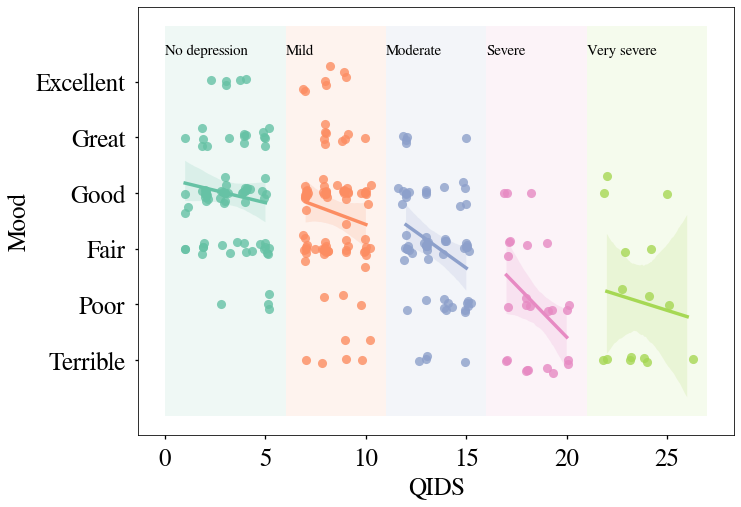

[[25  1]
 [23  2]
 [22  0]
 [24  2]
 [22  0]
 [23  0]
 [26  0]
 [25  3]
 [24  0]
 [22  3]
 [24  0]
 [24  1]
 [22  3]
 [23  1]
 [23  0]]


In [135]:
xname = 'QIDS'
yname = 'Mood'
fontsize = 25
#plt.scatter(ipip_pd[xname] + np.random.randn(len(ipip_pd))/10, 
#            ipip_pd[yname] + np.random.randn(len(ipip_pd))/10, alpha=1)

qids_levels = [0, 6, 11, 16, 21, 27]
qids_names = ['No depression', 'Mild', 'Moderate', 'Severe', 'Very severe']

for idx in range(len(qids_levels)- 1):
    sub_pd = ipip_pd[(ipip_pd['QIDS'] > qids_levels[idx])*(ipip_pd['QIDS'] < qids_levels[idx+1])]
    sns.regplot(x=xname, y=yname,
                data=sub_pd,
                x_jitter=np.random.randn(len(sub_pd))/5,
                y_jitter=np.random.randn(len(sub_pd))/5,
                label=qids_names[idx])
    plt.fill_between(x=np.arange(qids_levels[idx], qids_levels[idx+1]+0.15, 0.5),
                     y1=-1, y2=6, alpha=0.1)

    # Regress to find relevance
    est = sm.GLS(endog=sub_pd['Mood'], exog=sub_pd['QIDS'], missing='drop')
    est2 = est.fit()
    print(est2.summary())
    
    plt.annotate(qids_names[idx], xy=(qids_levels[idx], 5.5), fontsize=15)
plt.xlabel(xname, fontsize=25)
plt.ylabel(yname, fontsize=25)
plt.yticks([0, 1, 2, 3, 4, 5],
           labels=['Terrible', 'Poor', 'Fair', 'Good', 'Great', 'Excellent'],
           fontsize=25)
plt.xticks(fontsize=25)
plt.tight_layout()
plt.savefig('%s/mood_vs_QIDS_scatter_pre_mental.pdf'%saveroot)
plt.show()

print(sub_pd[['QIDS', 'Mood']].to_numpy())

In [84]:
# Build databases for regulars, patients, and healthcare workers
patient_db = {key:db[key] for key in db if len(db[key]['I']) > 0}
caretaker_db = {key:db[key] for key in db if len(db[key]['M']) > 0}
healthcare_db = {key:db[key] for key in db if db[key]['healthcare_worker']}
others_db = {key:db[key] for key in db if (key not in patient_db) and (key not in caretaker_db) and (key not in healthcare_db)}

ipip_vals = np.array([val for val in utils.getall(db, 'ipip') if val != 'not supplied'])
print(ipip_vals.mean(0))
print(ipip_vals.std(0))

print('Patients: ', len(patient_db))
print('Caretaker: ', len(caretaker_db))
print('Healthcare: ', len(healthcare_db))
print('Others: ', len(others_db))


[1.98791541 1.10536254 1.93768882 2.01888218 2.16691843]
[0.52885518 0.70546364 0.74468628 0.55206831 0.54524242]
Patients:  91
Caretaker:  50
Healthcare:  310
Others:  789


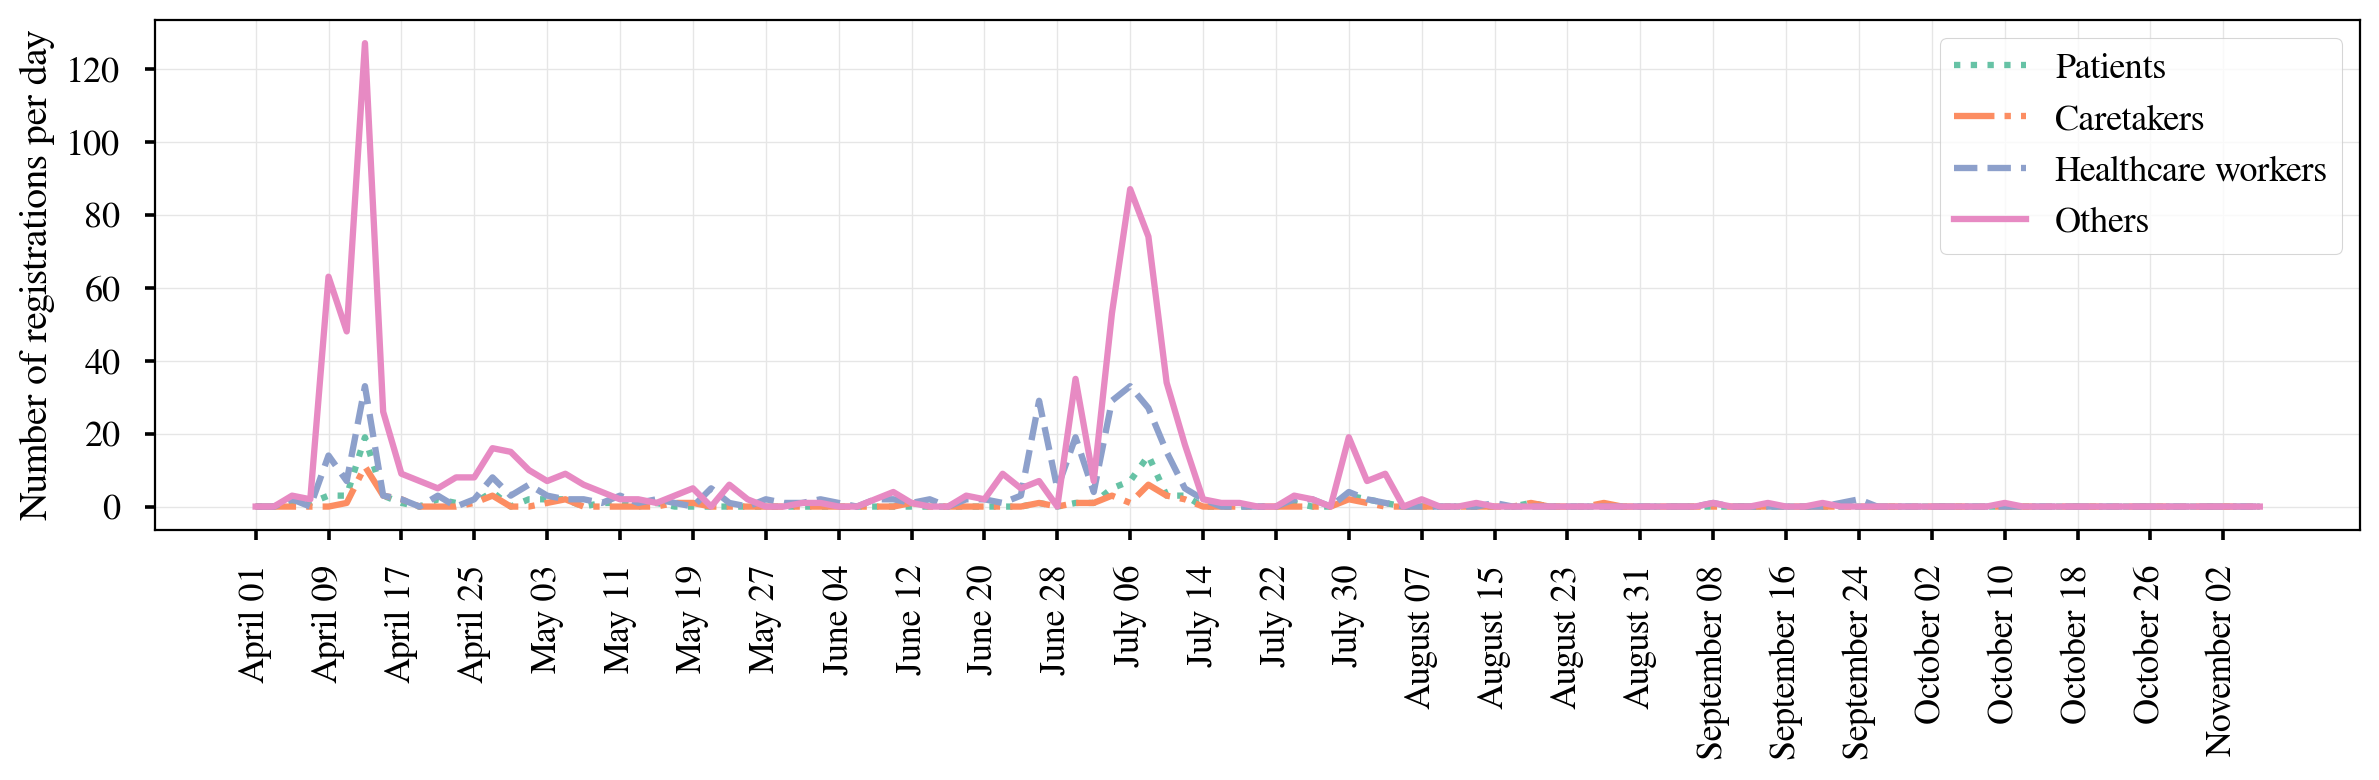

In [124]:
# Registration times for various classes
epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = datetime.datetime(2020, 11, 9, 0, 0).timestamp()

bins = np.arange(epoch1, epoch2, 60*60*24*2)

labels = ['Patients', 'Caretakers', 'Healthcare workers', 'Others']
linestyles = [':', '-.', '--', '-']
fig = plt.figure(figsize=(12, 4), dpi=200)
for idx, sub_db in enumerate([patient_db, caretaker_db, healthcare_db, others_db]):
    regtimes = utils.getall(sub_db, 'reg_time')
    values, _ = np.histogram(regtimes, bins=bins)

    plt.plot(bins[:-1], values, label=labels[idx], linestyle=linestyles[idx])

    lengths = [len(sub_db[entry]['QIDS']) for entry in sub_db]
    lengths.sort()

plt.legend()
plt.ylabel('Number of registrations per day')
plt.grid(color=(0.9, 0.9, 0.9), linewidth=0.5)
plt.xticks(bins[::4], labels=[d2s(binval*1000) for binval in bins[::4]], rotation='vertical')
plt.tight_layout()
plt.savefig('%s/regs_per_day.pdf'%saveroot)
plt.show()

Patients
Caretakers
Healthcare workers
Others


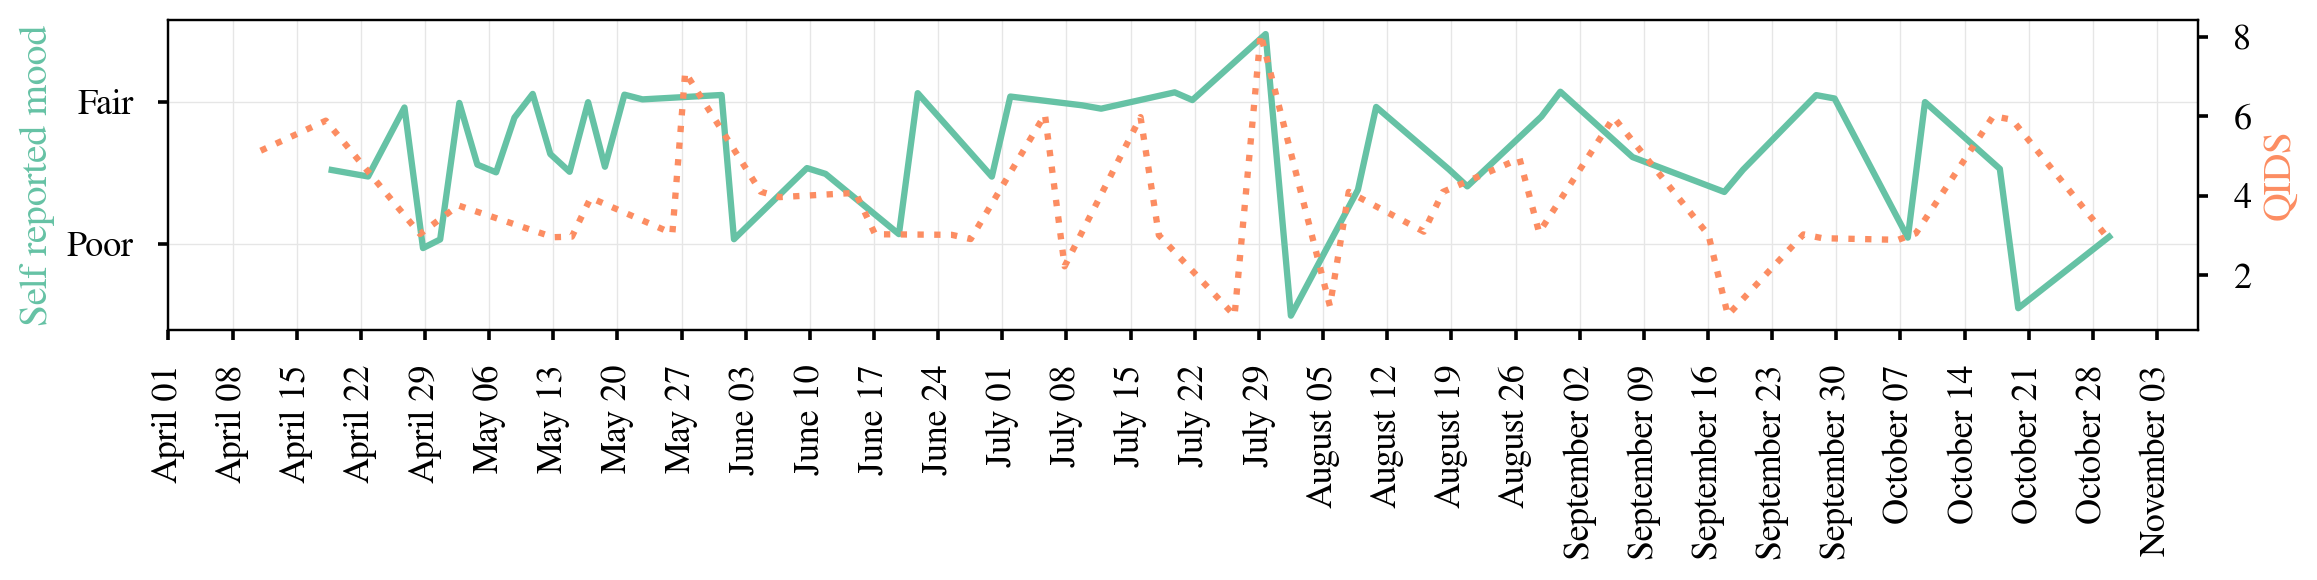

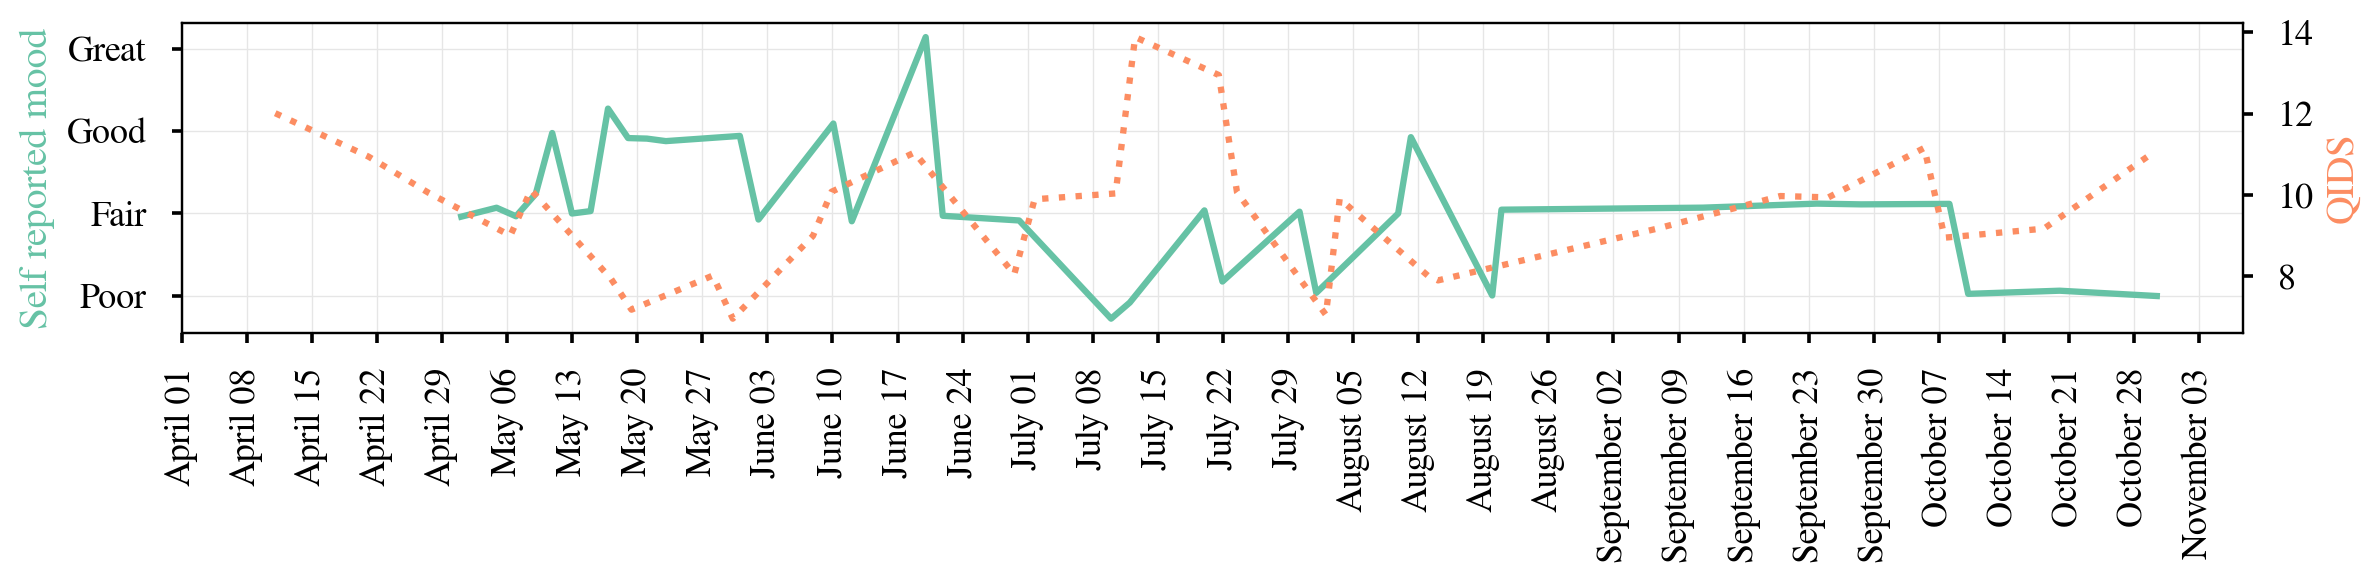

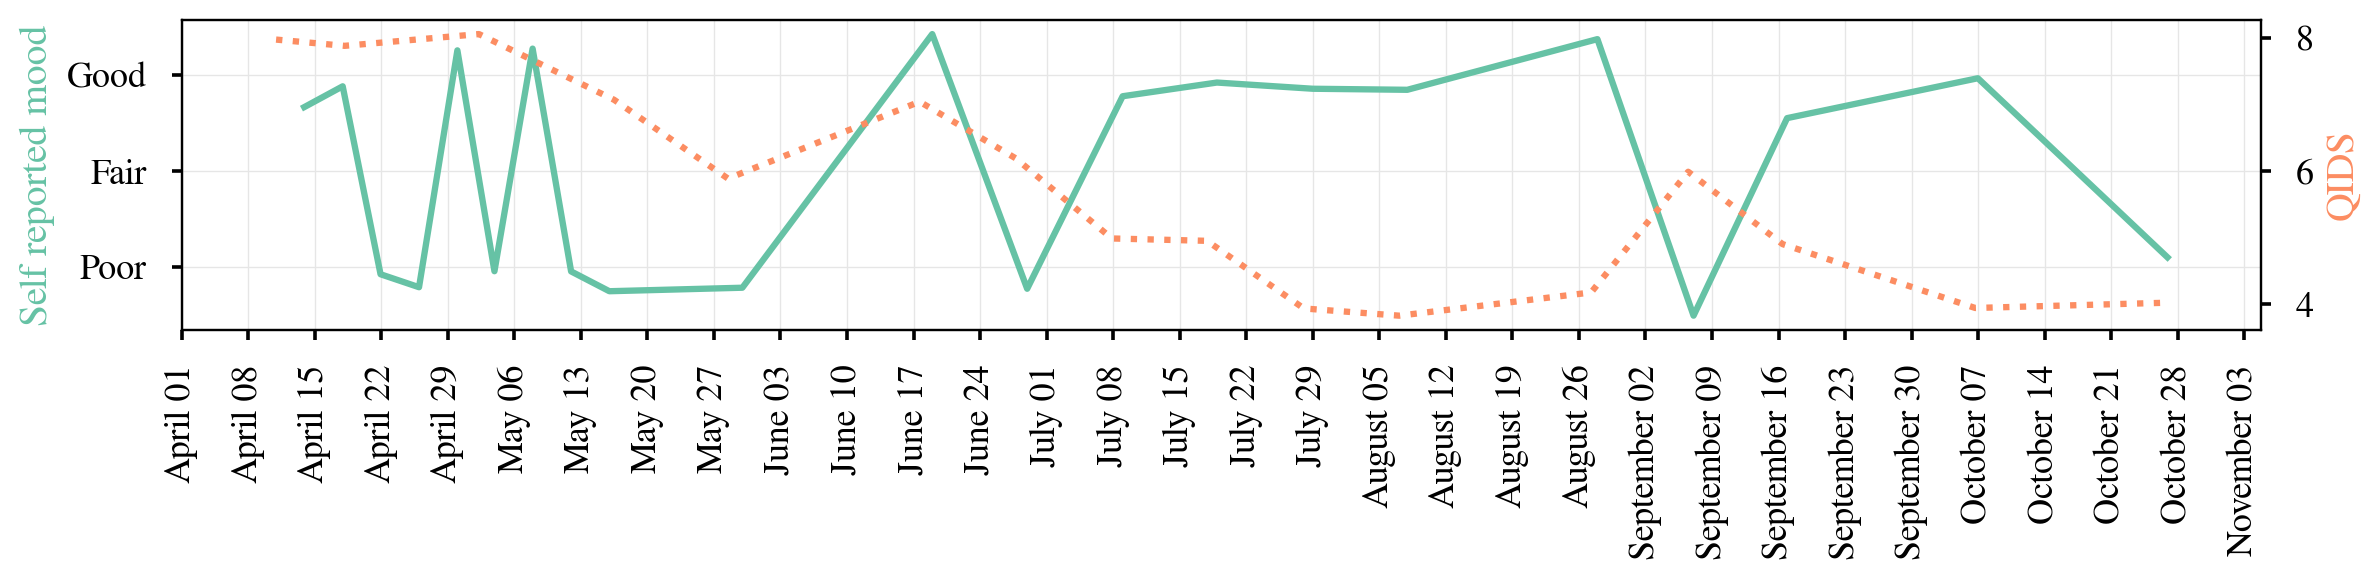

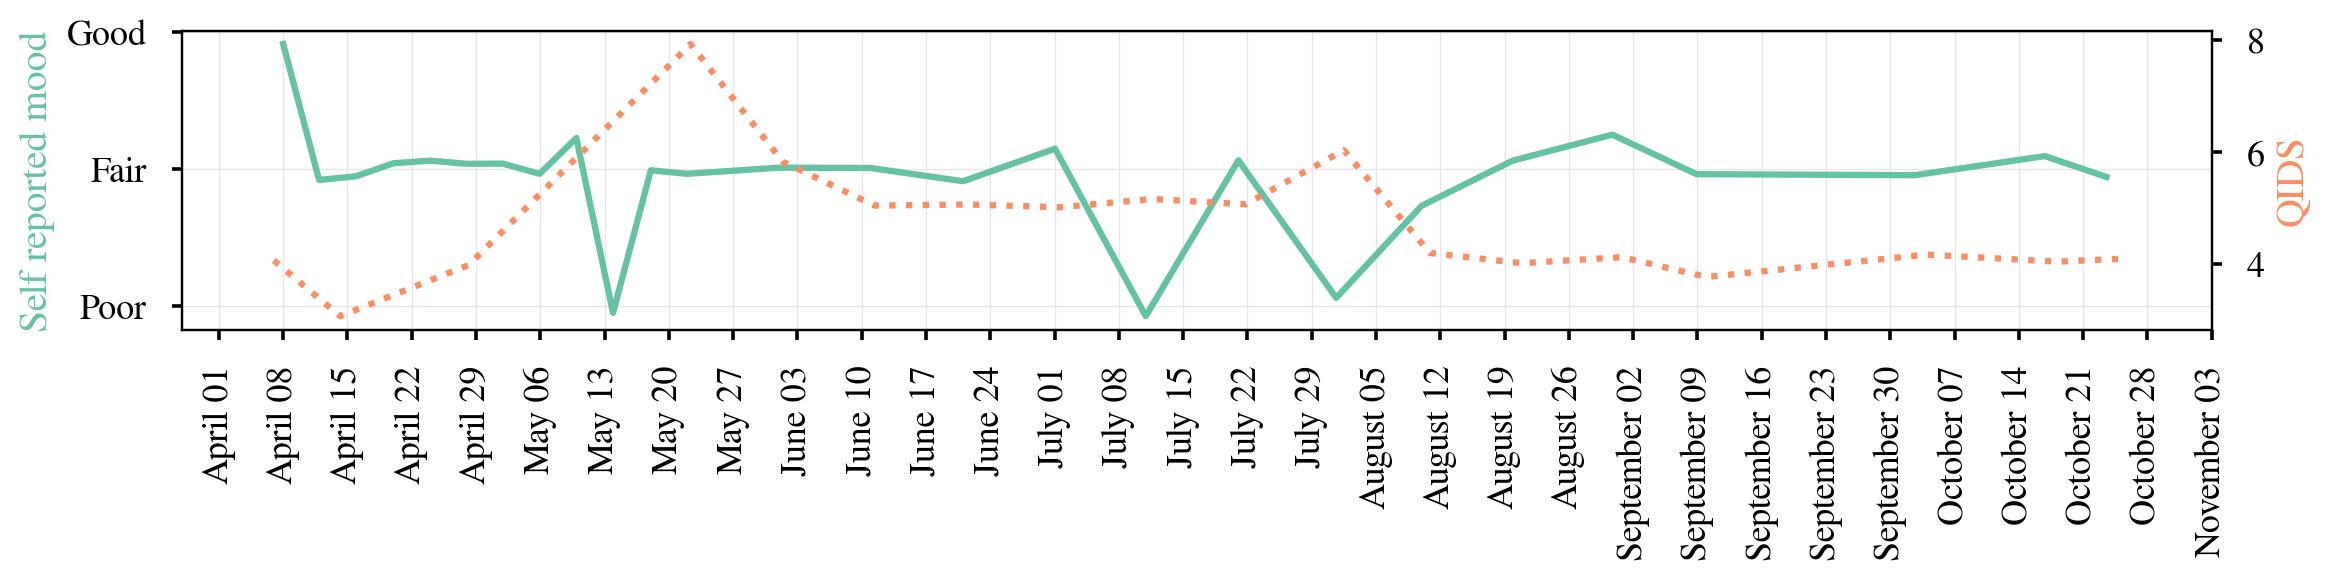

In [135]:
# Anecdotal timeseries
diligence_thres = 15

labels = ['Patients', 'Caretakers', 'Healthcare workers', 'Others']
linestyles = [':', '-.', '--', '-']

epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = datetime.datetime(2020, 11, 9, 0, 0).timestamp()

bins = np.arange(epoch1, epoch2, 60*60*24*7)

for idx, sub_db in enumerate([patient_db, caretaker_db, healthcare_db, others_db]):
    print(labels[idx])
    keys = np.array(list(sub_db.keys()))
    lengths = np.array([len(sub_db[entry]['QIDS']) for entry in sub_db])

    diligent_keys = keys[lengths > 15]

    fig = plt.figure(figsize=(12, 3), dpi=200)
    plt.clf()
    plt.subplot(111)
    ax = plt.gca()
    ax2 = ax.twinx()



    for diligent_key in [diligent_keys[0]]:
        A_panels = sub_db[diligent_key]['A']
        QIDS_panels = sub_db[diligent_key]['QIDS']

        moods = np.array([A_panel['mood'] for A_panel in A_panels])
        timestamps = np.array([A_panel['timestamp'] for A_panel in A_panels])

        color1 = next(ax._get_lines.prop_cycler)['color']
        color2 = next(ax._get_lines.prop_cycler)['color']

        qids = np.array(list(QIDS_panels.values()))
        qids_timestamps = np.array(list(QIDS_panels.keys())).astype(float)

        indices = np.argsort(timestamps)
        ax.plot(timestamps[indices], moods[indices] + np.random.randn(len(indices))/10, color=color1, linestyle='-')

        indices = np.argsort(qids_timestamps)
        ax2.plot(qids_timestamps[indices], qids[indices] + np.random.randn(len(indices))/10, color=color2, linestyle=':')
    
    ax.set_xticks(bins)
    ax.set_xticklabels([d2s(binval*1000) for binval in bins], rotation='vertical')
    ax.set_ylabel('Self reported mood', color=color1)
    ax.set_yticklabels(['Terrible', 'Poor', 'Fair', 'Good', 'Great', 'Excellent'])
    ax2.set_ylabel('QIDS', color=color2)
    ax.grid(color=(0.9, 0.9, 0.9), linewidth=0.5)
    plt.tight_layout()

    plt.savefig('%s/diligent_%s.pdf'%(saveroot, labels[idx]))

plt.show()



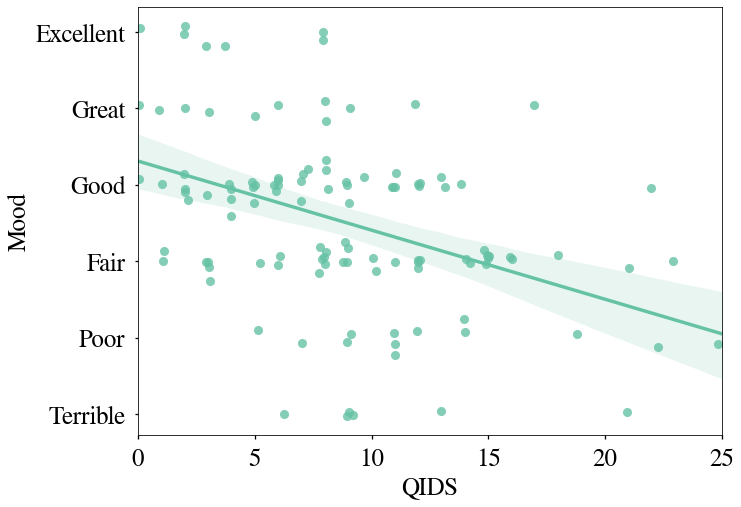

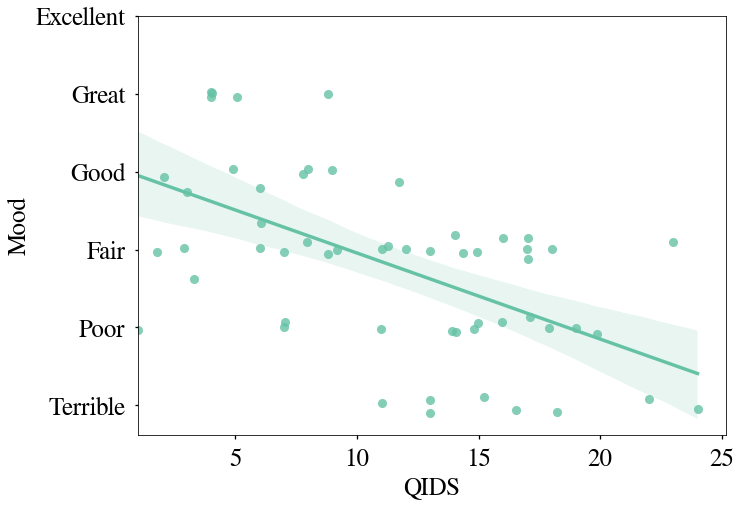

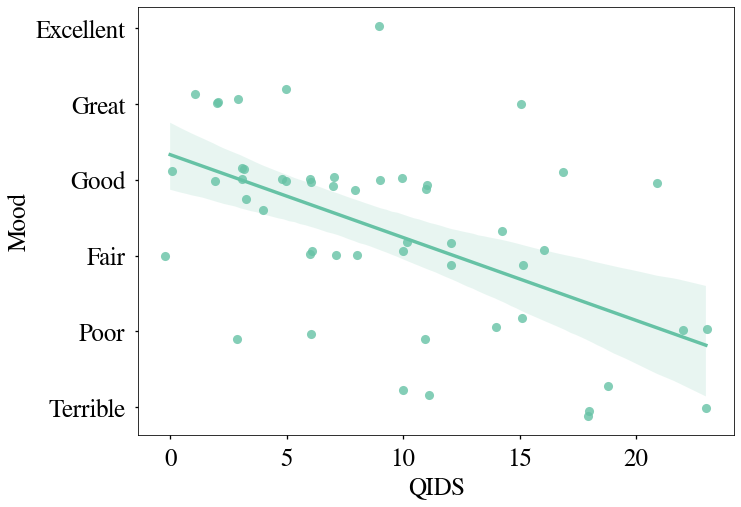

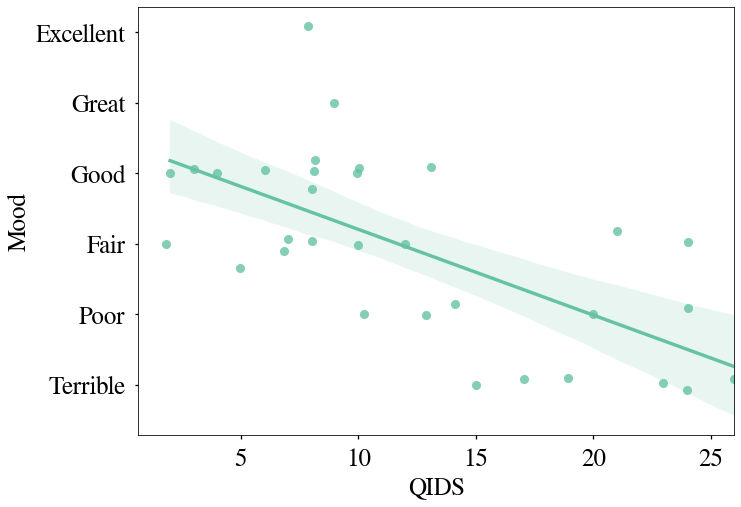

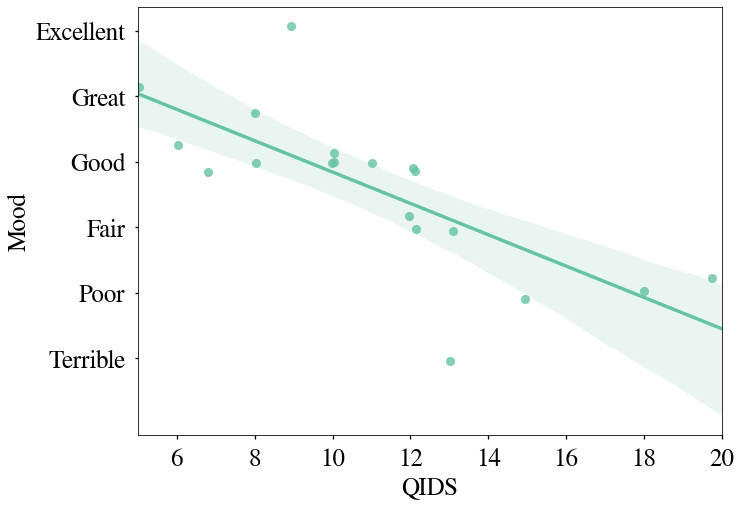

In [84]:
# Scatter plot for various countries
xname = 'QIDS'
yname = 'Mood'
fontsize = 25

countries = ['United States of America', 'South Africa', 'India', 'United Kingdom', 'México']

for idx in range(len(countries)):
    fig = plt.figure()
    sub_pd = ipip_pd[ipip_pd['Country'] == countries[idx]]
    sns.regplot(x=xname, y=yname,
                data=sub_pd,
                x_jitter=np.random.randn(len(sub_pd))/5,
                y_jitter=np.random.randn(len(sub_pd))/5,
                label=countries[idx])
    plt.xlabel(xname, fontsize=25)
    plt.ylabel(yname, fontsize=25)
    plt.yticks([0, 1, 2, 3, 4, 5],
            labels=['Terrible', 'Poor', 'Fair', 'Good', 'Great', 'Excellent'],
            fontsize=25)
    plt.xticks(fontsize=25)
    plt.tight_layout()

    plt.savefig('%s/mood_vs_QIDS_scatter_%s.pdf'%(saveroot, countries[idx]))
plt.show()

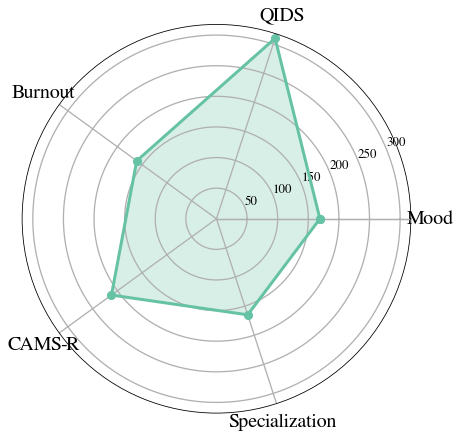

In [26]:
# Spider chart for healthcare workers
hkeys = [key for key in db if db[key]['healthcare_worker']]

#pprint.pprint(db[hkeys[0]])

values = [len([key for key in hkeys if len(db[key]['A']) > 0]),
          len([key for key in hkeys if len(db[key]['QIDS']) > 0]),
          len([key for key in hkeys if len(db[key]['K']) > 0]),
          len([key for key in hkeys if 'camsr' in db[key]]),
          len([key for key in hkeys if 'None of the above' not in db[key]['healthcare_job']])]

values = np.array(values)
labels = ['Mood', 'QIDS', 'Burnout', 'CAMS-R', 'Specialization']

angles = np.linspace(0, 2*np.pi, len(values), endpoint=False)

values = np.concatenate((values, [values[0]]))
angles = np.concatenate((angles, [angles[0]]))

fig = plt.figure()
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, values, 'o-', linewidth=3)
ax.fill(angles, values, alpha=0.25)
ax.set_thetagrids(angles * 180/np.pi, labels)
plt.xticks(fontsize=20)
ax.grid(True)

In [39]:
# Metrics per population
qids_vals = np.array([db[key]['camsr'] for key in db if len(db[key]['I']) == 0 and len(db[key]['M']) == 0 and db[key]['healthcare_worker'] == 0 and 'camsr' in db[key]])
print(qids_vals.mean(), qids_vals.std())

407
25.095823095823096 6.234812091504502


In [123]:
epoch1 = datetime.datetime(2020, 4, 1, 0, 0).timestamp()
epoch2 = datetime.datetime(2020, 6, 30, 0, 0).timestamp()

conversion_dict = {
    'None': ['none of the above', 'None', '(empty)'],
    'Mental health': ['depression', 'anxiety disorder',
               'other serious mental health issues',
               'obsessive compulsive disorder',
               'addiction (drug, alcohol)',
               'bipolar'],
    'Cardio-vascular': ['abnormal blood pressure',
                        'diabetes'],
    'Pulmonary': ['asthma', 'asthma, COPD or other lung disease'],
    'Other health issues': ['cancer', 'other serious health issues'] 
}

camsr_dict = {key:[] for key in conversion_dict}
ipip_dict = {key:[] for key in conversion_dict}
qids_dict = {key:[] for key in conversion_dict}
mood_dict = {key:[] for key in conversion_dict}

for key in db:
    physical = db[key]['pre_physical']
    mental = db[key]['pre_mental']

    if len(set(conversion_dict['None']).intersection(physical)) > 0 and\
       len(set(conversion_dict['None']).intersection(mental)) > 0:
        if 'camsr' in db[key]:
            camsr_dict['None'].append(db[key]['camsr'])
        if 'ipip' in db[key]:
            ipip_dict['None'].append(db[key]['ipip'])
        if len(db[key]['QIDS']) > 0:
            for qkey, qval in db[key]['QIDS'].items():
                if (float(qkey) > epoch1) and (float(qkey) < epoch2):
                    qids_dict['None'].append(qval)
        if len(db[key]['A']) > 0:
            for A in db[key]['A']:
                if (float(A['timestamp']) > epoch1) and (float(A['timestamp']) < epoch2):
                    mood_dict['None'].append(A['mood'])
    else:            
        if len(set(conversion_dict['Mental health']).intersection(mental)) > 0:
            if 'camsr' in db[key]:
                camsr_dict['Mental health'].append(db[key]['camsr'])
            if 'ipip' in db[key]:
                ipip_dict['Mental health'].append(db[key]['ipip'])
            if len(db[key]['QIDS']) > 0:
                for qkey, qval in db[key]['QIDS'].items():
                    if (float(qkey) > epoch1) and (float(qkey) < epoch2):
                        qids_dict['Mental health'].append(qval)
            if len(db[key]['A']) > 0:
                for A in db[key]['A']:
                    if (float(A['timestamp']) > epoch1) and (float(A['timestamp']) < epoch2):
                        mood_dict['Mental health'].append(A['mood'])
        for condition_name in ['Cardio-vascular', 'Pulmonary', 'Other health issues']:
            if len(set(conversion_dict[condition_name]).intersection(physical)) > 0:
                if 'camsr' in db[key]:
                    camsr_dict[condition_name].append(db[key]['camsr'])
                if 'ipip' in db[key]:
                    ipip_dict[condition_name].append(db[key]['ipip'])
                if len(db[key]['QIDS']) > 0:
                    for qkey, qval in db[key]['QIDS'].items():
                        if (float(qkey) > epoch1) and (float(qkey) < epoch2):
                            qids_dict[condition_name].append(qval)
                if len(db[key]['A']) > 0:
                    for A in db[key]['A']:
                        if (float(A['timestamp']) > epoch1) and (float(A['timestamp']) < epoch2):
                            mood_dict[condition_name].append(A['mood'])

qids_all = np.array([valsub for _, val in qids_dict.items() for valsub in val])
print(qids_all)
print(qids_all.mean(), qids_all.std())

camsr_dict = {key:np.array(camsr_dict[key]) for key in camsr_dict}
ipip_dict = {key:np.array(ipip_dict[key]) for key in ipip_dict}
qids_dict = {key:np.array(qids_dict[key]) for key in qids_dict}
mood_dict = {key:np.array(mood_dict[key]) for key in mood_dict}

camsr_mean = {key:camsr_dict[key][camsr_dict[key] > 0].mean() for key in camsr_dict}
camsr_std = {key:camsr_dict[key][camsr_dict[key] > 0].std() for key in camsr_dict}
camsr_min = {key:camsr_dict[key][camsr_dict[key] > 0].min() for key in camsr_dict}
camsr_max = {key:camsr_dict[key][camsr_dict[key] > 0].max() for key in camsr_dict}

ipip_mean = {key:ipip_dict[key].mean(0) for key in ipip_dict}
ipip_std = {key:ipip_dict[key].std(0) for key in ipip_dict}
ipip_min = {key:ipip_dict[key].min(0) for key in ipip_dict}
ipip_max = {key:ipip_dict[key].max(0) for key in ipip_dict}

mood_mean = {key:mood_dict[key].mean(0) for key in mood_dict}
mood_std = {key:mood_dict[key].std(0) for key in mood_dict}

qids_mean = {key:qids_dict[key].mean() for key in qids_dict}
qids_std = {key:qids_dict[key].std() for key in qids_dict}

idx = 4
print('IPIP')
for key in ipip_mean:
    print('%s: %.1f +/- %.1f'%(key, ipip_mean[key][idx], ipip_std[key][idx]))

print('\n')
print('QIDS')
for key in qids_mean:
    print('%s: %.1f +/- %.1f'%(key, qids_mean[key], qids_std[key]))

print('\n')
print('Mood')
for key in mood_mean:
    print('%s: %.1f +/- %.1f'%(key, mood_mean[key], mood_std[key]))

[ 3  3  4 ...  7 18 10]
7.010174880763116 4.558598312022086
IPIP
None: 2.2 +/- 0.5
Mental health: 2.2 +/- 0.6
Cardio-vascular: 2.2 +/- 0.5
Pulmonary: 2.2 +/- 0.6
Other health issues: 2.2 +/- 0.6


QIDS
None: 5.6 +/- 3.8
Mental health: 8.3 +/- 4.7
Cardio-vascular: 6.9 +/- 4.4
Pulmonary: 8.9 +/- 5.1
Other health issues: 7.2 +/- 4.8


Mood
None: 3.0 +/- 1.1
Mental health: 2.6 +/- 1.1
Cardio-vascular: 3.0 +/- 1.1
Pulmonary: 2.5 +/- 1.0
Other health issues: 2.9 +/- 1.0
